# Fashion MNIST using PCA

Data 100, Fall 2023

[Acknowledgments Page](https://ds100.org/fa23/acks/) and UC Santa Cruz

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ds100_utils import *

np.random.seed(23) #kallisti

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
sns.set()

# Load the Fashion-MNIST dataset

We will be using the Fashion-MNIST dataset, which is a cool little dataset with gray scale 28x28 images of articles of clothing.

Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747
https://github.com/zalandoresearch/fashion-mnist

## Load data

In [2]:
import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Downloading... Done!
Downloading... Done!
Downloading... Done!
Downloading... Done!


**Truncate Dataset**:
For the purposes of this demo, we're going to randomly sample
* 10,000 train datapoints, and
* 1,000 test datapoints.

In [3]:
rng = np.random.default_rng(42)
n_train, n_test = 10000, 1000
train_samples = rng.choice(np.arange(len(train_images)), size=n_train, replace=False)
test_samples = rng.choice(np.arange(len(test_images)), size=n_test, replace=False)

train_images, train_labels = train_images[train_samples,:,:], train_labels[train_samples]
test_images, test_labels = test_images[test_samples,:,:], test_labels[test_samples]

train_images.shape, test_images.shape

((10000, 28, 28), (1000, 28, 28))

## Visualizing images

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_dict = {i:class_name for i,class_name in enumerate(class_names)}

def show_train_image(index):
    plt.figure()
    # cmap=plt.cm.binary allows us to show the picture in grayscale
    plt.imshow(train_images[index], cmap=plt.cm.binary)
    plt.title(class_names[train_labels[index]])
    plt.colorbar() # adds a bar to the side with values
    plt.show()

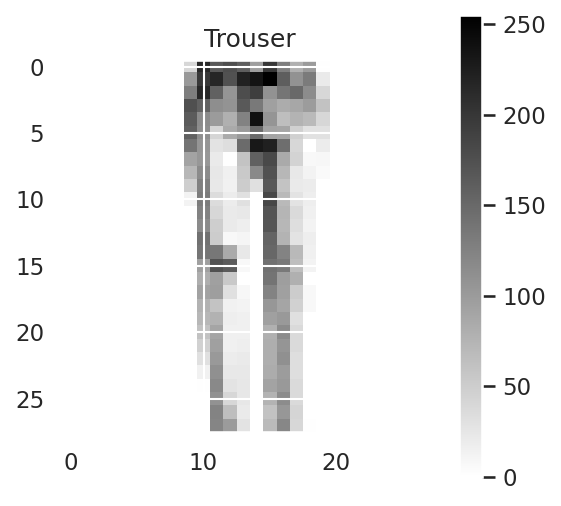

In [5]:
# Simply run this cell
show_train_image(0)

Let's see what kind of images we have overall.

There are 10 classes:

In [6]:
# there are 10 classes
print(len(class_names))
print(sorted(class_names))

10
['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt/top', 'Trouser']


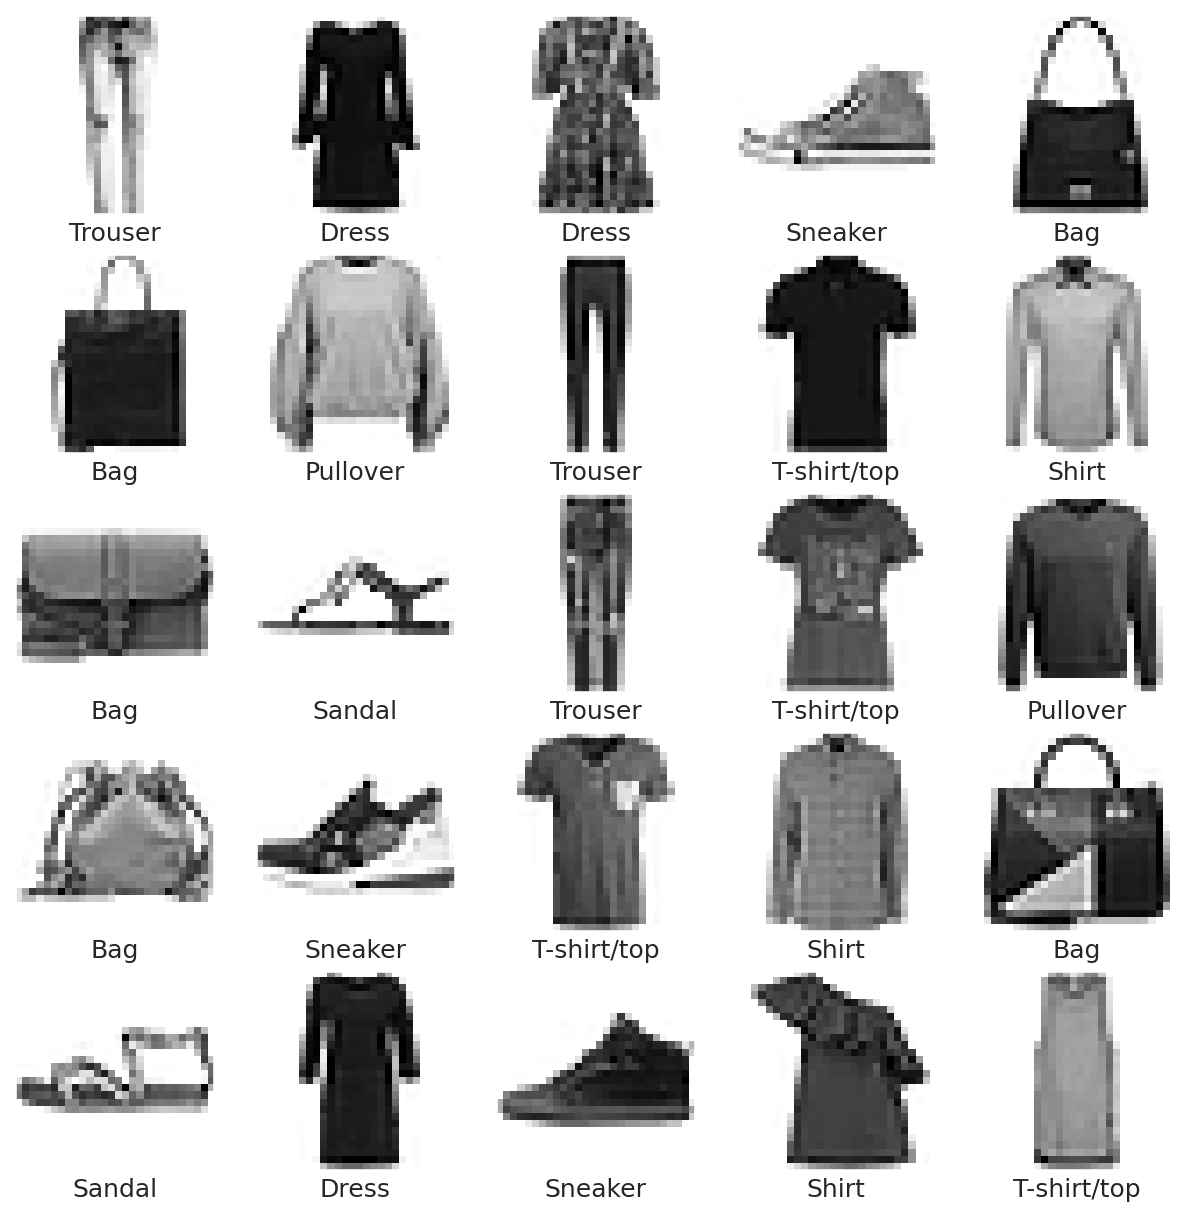

In [7]:
# Simply run this cell
# see documentation for subplot here:
# https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.subplot.html
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

# Goals of this demo

Suppose we would like to train a **logistic regression classifier** to distinguish between two specific classes of clothes. Note that logistic regression is a binary classifier; if you are interested in multi-class classification beyond this course, check out this [sklearn page](https://scikit-learn.org/stable/modules/multiclass.html).

We'd then like to check out two things:
* What do the data look like? Is it linearly separable?
* What features can we use?

## Preprocess:

### Normalize to 1

Pixel values are 0 (white) to 255 (black). When working with image data, generally we like to normalize to a range between 0 and 1:

Train Min:0.0 Max:1.0
Test Min:0.0 Max:1.0


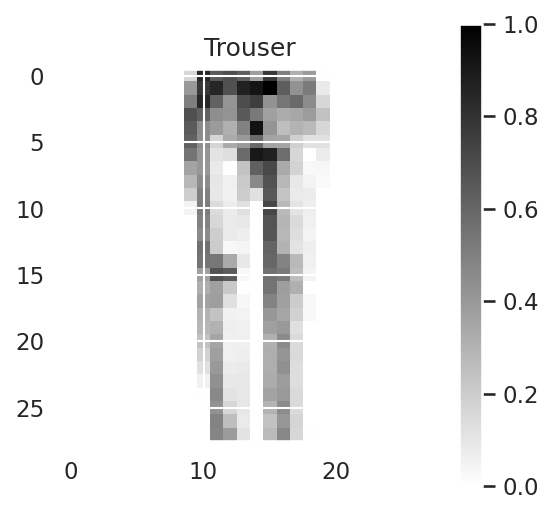

In [8]:
# just run this cell
train_images = train_images/255
test_images = test_images/255

print(f'Train Min:{train_images.min()} Max:{train_images.max()}')

print(f'Test Min:{test_images.min()} Max:{test_images.max()}')

show_train_image(0)

## Reshape features into 1-D

Recall that logistic regression relies on our features being 1-D, i.e., a vector, because we are trying to fit the model:

$$\hat{P}_{\theta}(Y = 1 | X = x) = \sigma(x^T \theta)$$

* Our data is composed of grayscale images (one channel) with a resolution of $28 \times28$.
* We can think of this as the images existing in a $28 \times 28=784$ dimensional space.
* We therefore need to reshape every single image in our dataset can be represented by a vector of length 784.

Using [`np.reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html), we reshape both train and test sets and convert them to a DataFrame:

In [9]:
# reshape pixels
train_images_vectors = np.reshape(train_images, (len(train_images), -1))
test_images_vectors = np.reshape(test_images, (len(test_images), -1))
train_images_vectors.shape, test_images_vectors.shape

((10000, 784), (1000, 784))

In [10]:
# then, add class/label to DataFrame
train_df = pd.DataFrame(train_images_vectors)
train_df['label'] = train_labels
train_df['class'] = train_df['label'].map(class_dict)

# reorder columns just so it's easier on the eyes
PIXEL_COLS = train_df.columns.tolist()[:-2]
LABEL_COLS = ['label', 'class']

cols_reorder = LABEL_COLS + PIXEL_COLS
train_df = train_df[cols_reorder]
train_df

,label,class,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,1,Trouser,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.003922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,3,Dress,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.243137,0.160784,0.000000,0.000000,0.007843,0.000000,0.000000,0.0,0.0,0.0
2,3,Dress,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.596078,0.584314,0.203922,0.196078,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,7,Sneaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,8,Bag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.576471,0.568627,0.509804,0.470588,0.556863,0.168627,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,Pullover,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.600000,0.223529,0.047059,0.0,0.0,0.0
9996,0,T-shirt/top,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.317647,0.137255,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9997,0,T-shirt/top,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007843,...,0.494118,0.619608,0.003922,0.000000,0.011765,0.000000,0.000000,0.0,0.0,0.0
9998,6,Shirt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [11]:
# do the same for test dataset
test_df = pd.DataFrame(test_images_vectors)
test_df['label'] = test_labels
test_df['class'] = test_df['label'].map(class_dict)

cols_reorder = LABEL_COLS + PIXEL_COLS
test_df = test_df[cols_reorder]

<br/><br/><br/>

## PCA

How would we visualize how the features (i.e., pixels) change with different classes? Would we have to pick random pixels to compare? Probably not. As humans, we can visualize the difference due to higher-order shapes and interactions between the pixels.

Enter PCA.

Here I use [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) which uses SVD under the hood:

> Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

Let's look at the train set. We'll run PCA to get the first 50 components:

In [12]:
from sklearn.decomposition import PCA

n_comps = 50
PCA_COLS = [f"pc{i+1}" for i in range(n_comps)]
pca = PCA(n_components=n_comps)
pca.fit(train_df[PIXEL_COLS])
principal_components = pca.transform(train_df[PIXEL_COLS])

In [13]:
# The first 50 components
principal_components.shape

(10000, 50)

### Explained Variance from PCs

Note that `sklearn.decomposition.PCA` has an attribute called `explained_variance_ratio_`:

> Percentage of variance explained by each of the selected components.



The first 50 components account for a reasonable amount of the total variance:

In [14]:
pca.explained_variance_ratio_

array([0.29204903, 0.17695613, 0.0596195 , 0.05026812, 0.03859675,
       0.03463695, 0.0236638 , 0.0184821 , 0.01302936, 0.01288355,
       0.00984057, 0.00914692, 0.00767584, 0.00674526, 0.00612661,
       0.00584359, 0.00559562, 0.00532868, 0.00458649, 0.00443497,
       0.00439464, 0.00410487, 0.00386062, 0.00371124, 0.00360238,
       0.00348955, 0.00331063, 0.0031289 , 0.00307494, 0.00285894,
       0.00272438, 0.00265853, 0.00263831, 0.00253123, 0.00251117,
       0.00238949, 0.00230739, 0.00224068, 0.00218739, 0.0020943 ,
       0.00204936, 0.00197996, 0.00193978, 0.00182668, 0.00175013,
       0.001736  , 0.00169792, 0.00165915, 0.00161304, 0.00154818])

In [15]:
np.sum(pca.explained_variance_ratio_)

0.8631295806642582

The first two components account for a little less than half of variance:

In [16]:
# PC1, PC2 component scores
np.sum(pca.explained_variance_ratio_[:2])

0.4690051583750244

Seem reasonable? Let's check out the scree plot:

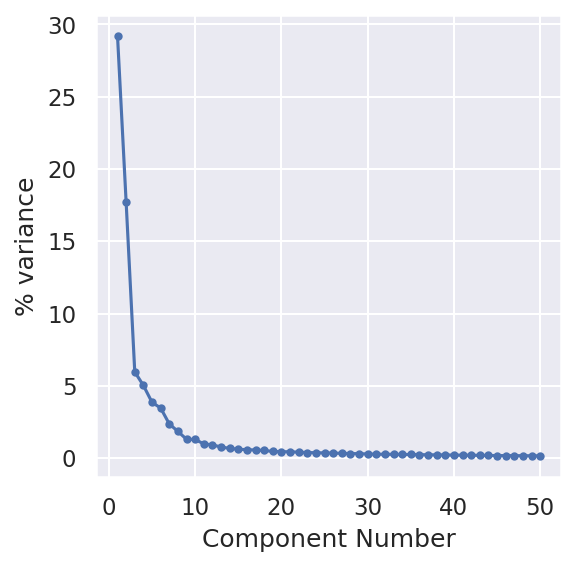

In [17]:
plt.plot(np.arange(n_comps)+1,
         100*pca.explained_variance_ratio_,
         marker='.');
plt.ylabel("% variance")
plt.xlabel("Component Number");

Visually the elbow looks closer to components 3 or 4, so we can't gather too much from the visualization, but let's try it out and see what happens:

## EDA: visualizations

In [18]:
def build_comps_df(components, label_df, colnames):
    df = pd.DataFrame(data=components,
                      columns=colnames)
    df["class"] = label_df["class"]
    df["label" ] = label_df["label"]
    return df

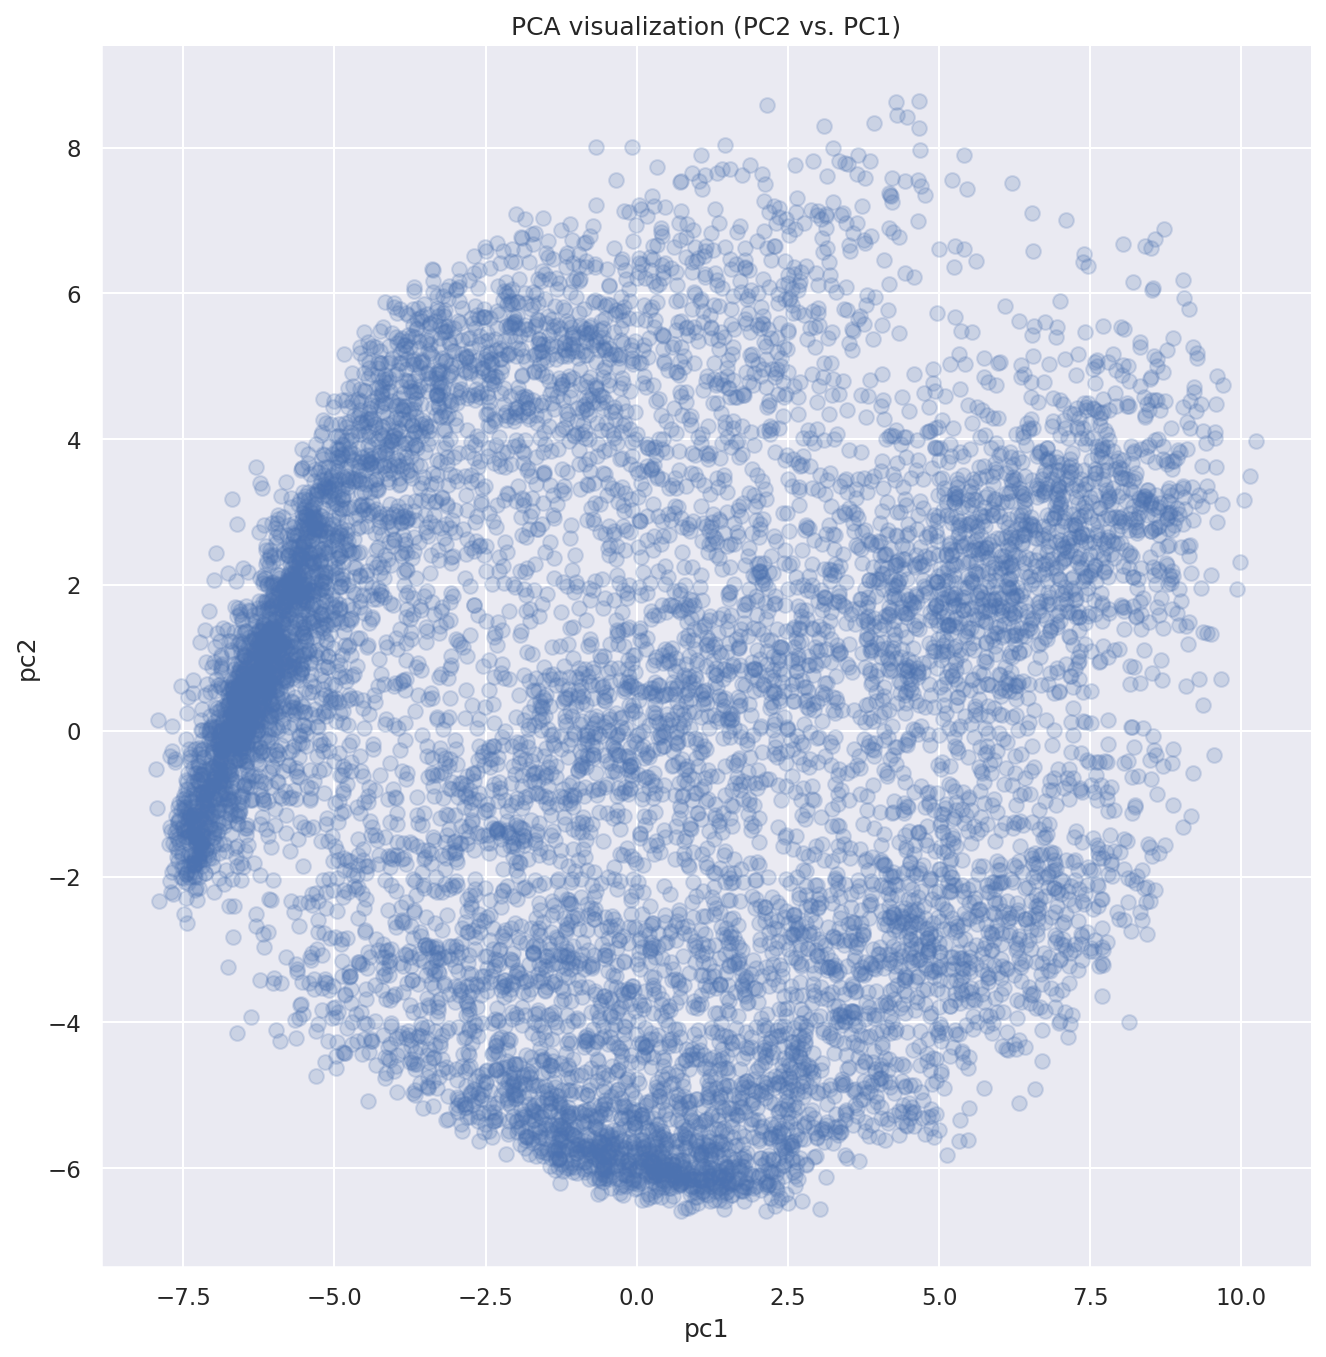

In [19]:
pca_df = build_comps_df(principal_components, train_df, PCA_COLS)
# plot pca, uncomment for classes.
sns.lmplot(x='pc1',
           y='pc2',
           data=pca_df, 
           fit_reg=False, 
           # hue='class',
           height=9,
           scatter_kws={"s":50,"alpha":0.2})
plt.title("PCA visualization (PC2 vs. PC1)");

We can see some patterns, but ultimately the scatter plot isn't well-separated.

If we're looking to keep visualizing, next we can look at different dimensionality reduction algorithms like t-SNE.

## Optional: t-SNE: a random embedding

t-SNE is another dimensionality reduction algorithm that is **out of scope for this course** but is frequently used for EDA in machine learning topics.
* At a high level, it is a nonlinear stochastic (random) algorithm that models each datapoint such that "similar" datapoints are nearby and "dissimilar" datapoints are distant with high probability.
* It relies on minimizing KL divergence between a high- and low-dimensional distribution of datapoints.
* t-SNE is not particularly effectively immediately out of the box; in practice, first apply PCA to obtain principal components that represent most of the dataset variability, then apply t-SNE.
* Because of the stochasticity (randomness) of t-SNE, sometimes false clusters can appear and/or mappings are uninterpretable. PCA is better for interpreting relative distance between different points, no matter their distance. PCA is also better for transforming new data to the same space.
* See [source1](https://datascience.stackexchange.com/questions/56758/why-is-pca-often-used-before-t-sne-for-problems-when-the-goal-is-only-to-reduce), [source2](https://stats.stackexchange.com/questions/238538/are-there-cases-where-pca-is-more-suitable-than-t-sne)

Let's use t-SNE to see whether clusters appear that match the fashion MNIST labels. Note that I've tweaked the below to have specific perplexity parameters, learning rates, etc. Check out the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for more details.

In [20]:
from sklearn.manifold import TSNE

In [21]:
# Simply run this cell
TSNE_COLS = ["z1", "z2"]

tsne_model = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=200, n_iter=1000)

Running the below cell might take some time:

In [22]:
tsne_comps = tsne_model.fit_transform(principal_components)

Let's visualize the t-SNE vectors. Note that all embeddings are built off of the principal components, which are rotations of the original features.

When we add class labels to the visualization, notice that t-SNE's clusters correspond reasonably well.

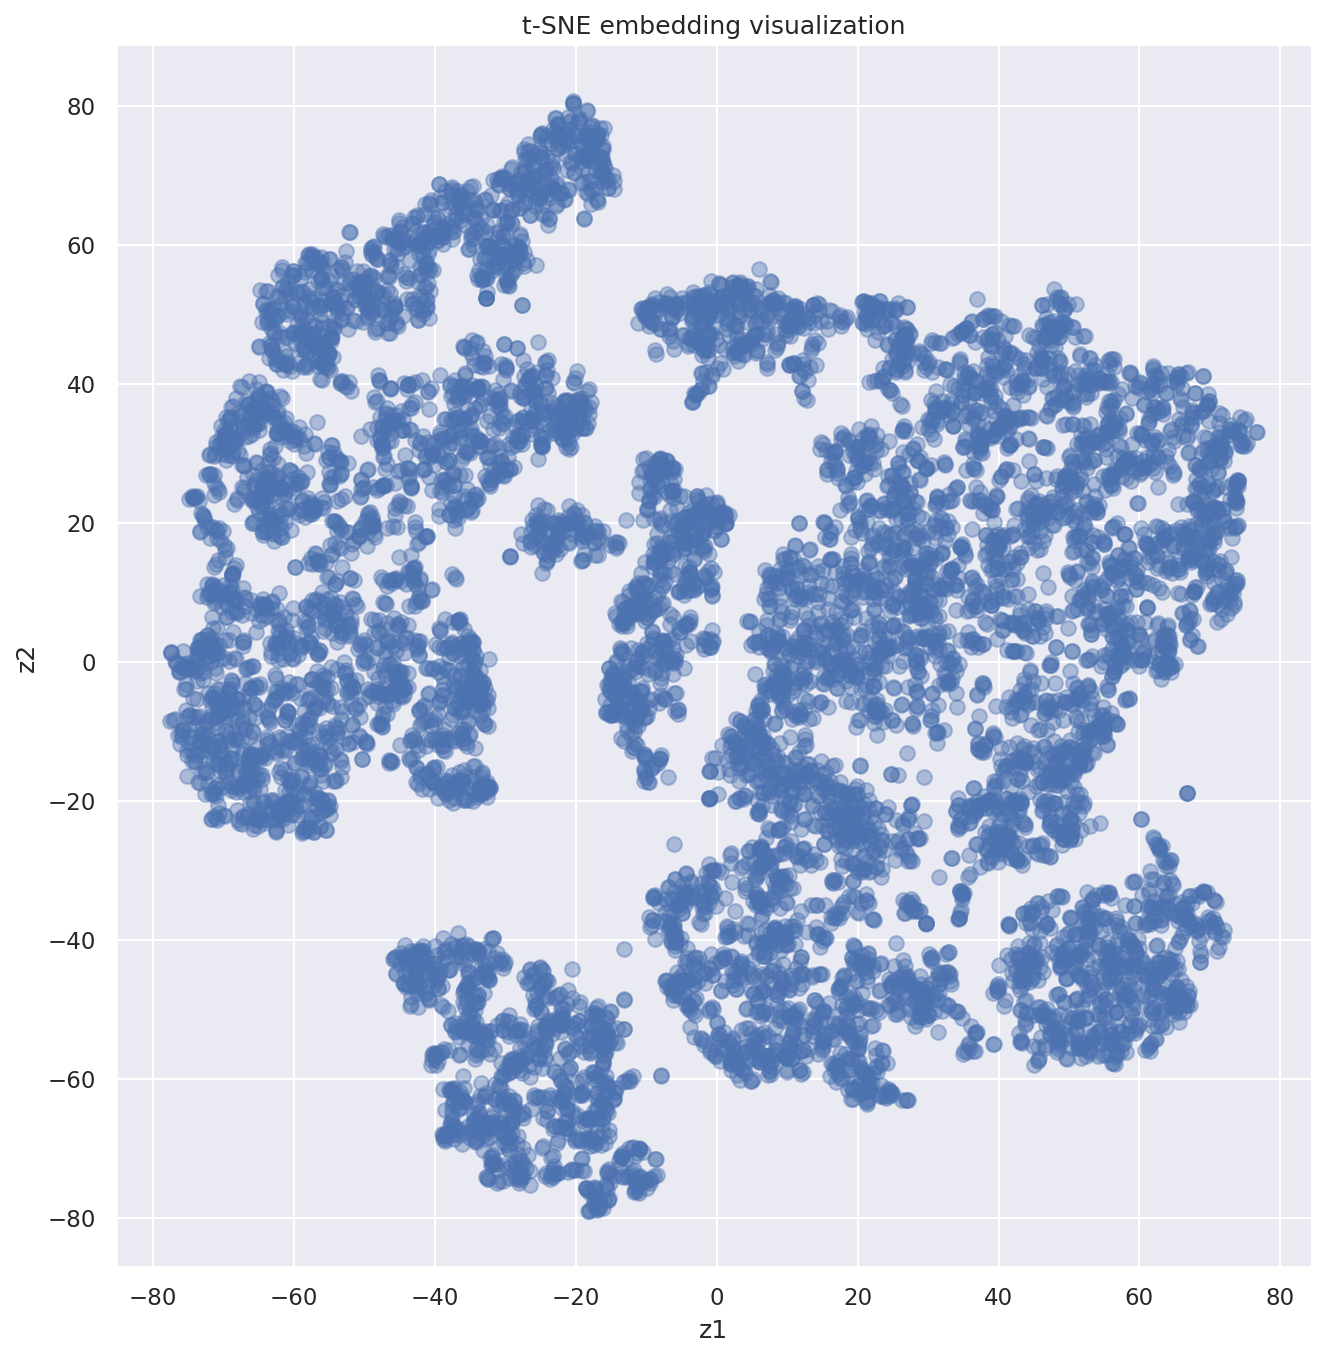

In [23]:
tsne_df = build_comps_df(tsne_comps, train_df, TSNE_COLS)

# t-SNE embeddings separate features.
# uncomment to see how these feature clusters correspond to class labels
sns.lmplot(x='z1',
           y='z2',
           data=tsne_df, 
           fit_reg=False, 
           # hue='class',
           height=9,
           scatter_kws={"s":50,"alpha":0.4})
plt.title("t-SNE embedding visualization");

<br/><br/>

---

# Logistic Regression

Since Logistic Regression creates a binary classifier, let's consider classifying a subset of the data.

The below helper function takes the subset of train data for two given labels.

In [24]:
def get_data_subset_binary(df, class0, class1, featnames, shuffle=True, shuffle_seed=42):
    df_filtered = df[(df["class"] == class0) | (df["class"] == class1)].copy()
    df_filtered["binary_label"] = 0
    df_filtered.loc[df["class"] == class1, "binary_label"] = 1
    data = df_filtered[featnames].values
    labels = df_filtered["binary_label"].values
    return data, labels

## Classifier 1: Trouser vs. Ankle boot

Let's train a logistic regression model against this subset of data:
* **"Trouser" (0)**
* **"Ankle boot" (1)**.

We are going to train on the principal components, and **not** the $28 \times 28 = 784$ pixel features. In other words this is what we have/will be doing:

1. Use PCA to get top 50 principal components.
1. Take only the data labeled Trouser and Ankle boot.
1. Train a Logistic Regression model on the 50 principal components.


**Why would we train Logistic Regression on principal components?** Recall that the orthogonality properties of $U$ and $V$ mean that principal components are orthogonal. Thus PCA effectively reduces multicollinearity between features (which otherwise would be very prevalent in our original pixel data).


In [25]:
data_bottoms, labels_bottoms = get_data_subset_binary(pca_df, "Trouser", "Ankle boot", PCA_COLS)
print(len(data_bottoms), "datapoints")

1972 datapoints


In [26]:
from sklearn.linear_model import LogisticRegression

model_bottoms = LogisticRegression(random_state=42, solver="sag")

In [27]:
model_bottoms.fit(data_bottoms, labels_bottoms)

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(random_state=42, solver='sag')

How does our model do? Let's check the train accuracy:

In [28]:
from sklearn.metrics import accuracy_score

preds_bottoms = model_bottoms.predict(data_bottoms)
accuracy_score(labels_bottoms, preds_bottoms)

1.0

### Classifier 1: Linearly separable?

Why do you think this model perfectly fits the train data?

Check out the quasi-linear separability in PC1 and PC2 below. Remember:
* "Trouser" (0)
* "Ankle boot" (1).

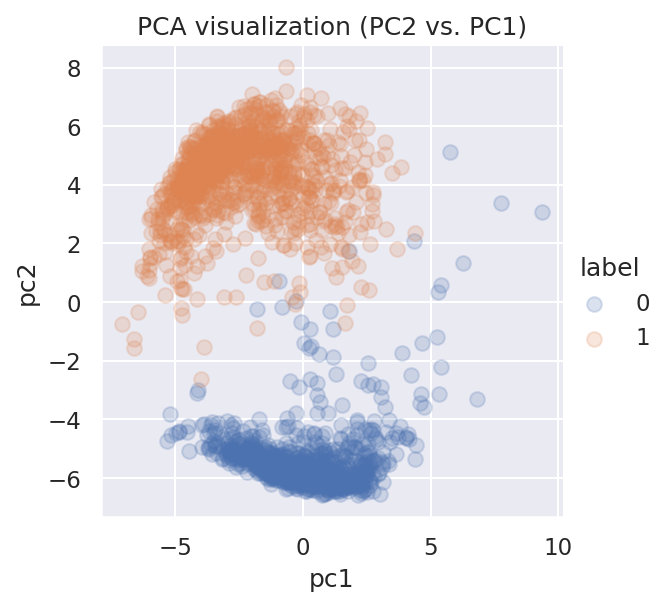

In [29]:
# plot pca, uncomment for classes.
visualize_df = pd.DataFrame(
    {"pc1": data_bottoms[:,0],
     "pc2": data_bottoms[:,1],
     "label": labels_bottoms
    })
sns.lmplot(x="pc1",
           y="pc2",
           fit_reg=False,
           data=visualize_df,
           hue="label",
           height=4,
           scatter_kws={"s":50,"alpha":0.2})
plt.title("PCA visualization (PC2 vs. PC1)");

It's possible that these two classes generate fully separable clusters of datapoints when we incorporate all 50 principal components, which is what our logistic regression model fits to.

### Classifier 1: Test performance

General outline of steps:
1. Rotate original test data into principal components **using the same linear transformation as train.** This was stored in the object `pca`.
1. Take subset of data with the target binary labels.
1. Predict pca test data using the Logistic Regression model **trained on training data.** This was stored in the model `model_bottoms`.

In [30]:
# 1. rotate test data to "principal components" space
principal_components = pca.transform(test_df[PIXEL_COLS])
pca_test_df = build_comps_df(principal_components, test_df, PCA_COLS)

# 2. subset with target binary labels 
data_bottoms_test, labels_bottoms_test = \
    get_data_subset_binary(pca_test_df, "Trouser", "Ankle boot", PCA_COLS)
print(len(data_bottoms_test), "datapoints")

209 datapoints


In [31]:
# 3. predict using logistic regression
preds_bottoms_test = model_bottoms.predict(data_bottoms_test)
accuracy_score(labels_bottoms_test, preds_bottoms_test)

1.0

Nice...!!!

## Classifier 2: Pullover vs. Coat

Let's train a logistic regression model against this subset of data:
* **"Pullover" (0)**
* **"Coat" (1)**.

In [32]:
data_tops, labels_tops = get_data_subset_binary(pca_df, "Pullover", "Coat", PCA_COLS)
print(len(data_tops), "datapoints")

2003 datapoints


In [33]:
from sklearn.linear_model import LogisticRegression

model_tops = LogisticRegression(verbose=False, random_state=42, solver="sag")
model_tops.fit(data_tops, labels_tops)

LogisticRegression(random_state=42, solver='sag', verbose=False)

In [34]:
preds_tops = model_tops.predict(data_tops)
accuracy_score(labels_tops, preds_tops)

0.8642036944583126

On test:

In [35]:
# 1. (done earlier) rotate test data to "principal components" space
# 2. subset with target binary labels 
data_tops_test, labels_tops_test = \
    get_data_subset_binary(pca_test_df, "Pullover", "Coat", PCA_COLS)
print(len(data_tops_test), "datapoints")

190 datapoints


In [36]:
# 3. predict using logistic regression
preds_tops_test = model_tops.predict(data_tops_test)
accuracy_score(labels_tops_test, preds_tops_test)

0.8736842105263158

### Classifier 2: Linearly Separable?

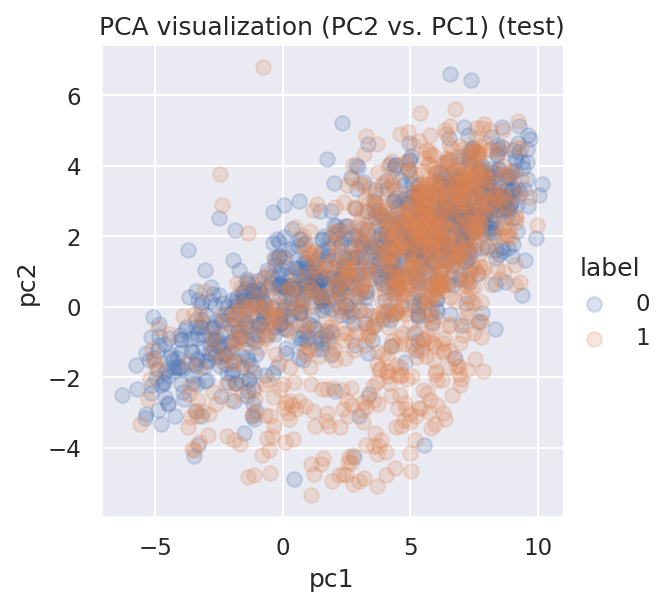

In [37]:
# plot pca, uncomment for classes.
visualize_df = pd.DataFrame(
    {"pc1": data_tops[:,0],
     "pc2": data_tops[:,1],
     "label": labels_tops
    })
sns.lmplot(x="pc1",
           y="pc2",
           fit_reg=False,
           data=visualize_df,
           hue="label",
           height=4,
           scatter_kws={"s":50,"alpha":0.2})
plt.title("PCA visualization (PC2 vs. PC1) (test)");

<br/><br/>

---

## Classifier 3: Original Pixels, Trousers vs. Ankle Boots

* "Trouser" (0)
* "Ankle boot" (1).

In [38]:
data3, labels3 = get_data_subset_binary(train_df, "Trouser", "Ankle boot", PIXEL_COLS)
print(len(data3), "datapoints")

1972 datapoints


In [39]:
from sklearn.linear_model import LogisticRegression

model3 = LogisticRegression(verbose=False, random_state=42, solver="sag", max_iter=30)
model3.fit(data3, labels3)

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=30, random_state=42, solver='sag', verbose=False)

Train set performance:

In [40]:
preds3 = model3.predict(data3)
accuracy_score(labels3, preds3)

1.0

Test set performance:

In [41]:
data3_test, labels3_test = get_data_subset_binary(train_df, "Pullover", "Coat", PIXEL_COLS)
print(len(data3_test), "datapoints")

preds3 = model3.predict(data3)
accuracy_score(labels3, preds3)

2003 datapoints


1.0

Okay, so PCA pre-processing doesn't help amazingly here, because our data are generally low feature and likely linear. However, PCA greatly speed up the training process, because our logistic regression formula no longer needed to worry about collinearly related features.